# Spice Data Reduction
***

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import csv
import math

def get_pol(fr):
    return (fr - 1)/(1 + fr)

def get_scan(number):    #returns the data file scan number in Spice format
    const = 3
    if (number > 999):    #no leading zeros
        zeros = 0
    else:
        if (number == 0):
            zeros = const
        else:
            zeros = const - int(math.floor(math.log10(number)))
    return '0'*zeros + str(number)

default_order = ['detector','time','count rate','nut_pre','psa','psb','fgen_ampl','fgen_freq', \
                 'cav_rot','cav_trans','monitor', 'q','k','h','l','ei','ef','e','psa_current','psb_current']
default_dict = {i[1]:i[0] for i in enumerate(default_order)}

def load_data(path, names, dest, write_data=False, overwrite=False, reorder=False):    #data loading function from Spice format
    """Returns the list [scan number, scan date, scan time start, user input scan titles, matrix of data from scan]."""
    scan_nums,dates,times,scan_titles,parms,data =[[],[],[],[],[],[]]
    for i in range(len(names)):
        file = open(path + names[i])
        lines = file.readlines()
        lines = [i.replace('\n','') for i in lines]    #removes new line characters
        file.close()
        
        scan_nums.append(lines[0][2::])    #line number determined by Spice format
        scan_nums[i] = scan_nums[i].split(' = ',)[1]
        dates.append(lines[1][2::])
        dates[i] = dates[i].split(' = ',)[1]
        times.append(lines[2][2::])
        times[i] = times[i].split(' = ',)[1]
        scan_titles.append(lines[10][2::])
        scan_titles[i] = scan_titles[i].split(' = ',)[1]
        parms.append(lines[29][7::].split())
        parms[i].append('count rate')
        data.append([j.split()[1::] for j in lines[30::] if (j[0] != '#')])    #assigns the data
        data[i] = [[float(data[i][j][k]) for j in range(len(data[i]))] for k in range(len(data[i][0]))]#HERE'S THE BUG    #converts to float
        data[i] = [list(j) for j in zip(*data[i])]    #transposes table
        
        time_normed_counts = [data[i][j][2]/data[i][j][1] if (data[i][j][1] != 0) else 0 for j in range(len((data[i])))]
        for j in range(len(data[i])):
            data[i][j].append(time_normed_counts[j])
        
        if ((reorder == True) and (parms[i] != default_order)):    #rearranges the columns to default_order
            swap_i = []    #columns to swap
            for j in range(len(parms[i])):
                swap_i.append([j, default_dict[parms[i][j]]])

            swaped_data = [ [0]*len(data[i][0]) for _ in range(len(data[i]))]    #matrix to hold swaped values
            for j in range(len(data[i])):    #slow swapping method, may need some work...
                for k in range(len(data[i][j])):
                    for m in range(len(swap_i)):
                        if (swap_i[m][1] == k):
                            swaped_data[j][k] = data[i][j][m]
                            parms[i][m] = default_order[swap_i[m][0]]    
            data[i] = swaped_data
            
        if (write_data == True):    #writes data to csv files
            if (overwrite == True):
                c_str = 'w'
            else:
                c_str = 'x'    #Fails if the file already exists
            windows_fname = scan_titles[i]    #Cleans the Spice file names for Windows
            invalid = '<>:"/\|?*'
            for char in invalid:
                windows_fname = windows_fname.replace(char,'')
            with open(dest_path + "scan" + str(scan_nums[i]) + "_" + windows_fname + ".csv", c_str, newline='') as csv_file:
                writer = csv.writer(csv_file)
                writer.writerow([scan_titles[i]])
                writer.writerow([dates[i]])
                writer.writerow([times[i]])
                writer.writerow(parms[i])
                for j in range(len(data[i])):
                    writer.writerow(data[i][j])
    
    return scan_nums,dates,times,scan_titles,parms,data

data_path = "C:/SpICE/User/exp3/Datafiles"
dest_path = 'C:/Users/HB2DUser/Desktop/Spice_data'    #WARNING: may overwrite files in destination folder!

In [4]:
if "pass":
    print('yes')

yes


In [3]:
print('This list defines the names of the columns extracted from SPICE: \n')
print(default_dict)

This list defines the names of the columns extracted from SPICE: 

{'detector': 0, 'time': 1, 'count rate': 2, 'nut_pre': 3, 'psa': 4, 'psb': 5, 'fgen_ampl': 6, 'fgen_freq': 7, 'cav_rot': 8, 'cav_trans': 9, 'monitor': 10, 'q': 11, 'k': 12, 'h': 13, 'l': 14, 'ei': 15, 'ef': 16, 'e': 17, 'psa_current': 18, 'psb_current': 19}


In [86]:
def efficiency(N_00, N_10, N_01, N_11):
    eRF1 = .5*(1 - (N_11 - N_01)/(N_10 - N_00))
    eRF2 = .5*(1 - (N_11 - N_10)/(N_01 - N_00))
    PA = (N_00 - N_10)*(N_00 - N_01)/(N_00*N_11 - N_01*N_10)
    print('[RF1 eff, RF2 eff, Pol/Ana eff:]')
    return [round(i*100,3) for i in [eRF1, eRF2, PA]]

In [92]:
file_range = range(209,211) #doesn't include endpoint!
#file_range = range(59,61) #doesn't include endpoint!
file_list = ["/CG4B_exp0003_scan" + get_scan(i) + ".dat" for i in file_range]

Num,Date,Time,Title,Parms,Data = load_data(data_path, file_list, dest_path, write_data=False, overwrite=False, reorder=True)
Data = np.copy(Data)
Data = Data.T

***
# Analysis
***

Flip efficiency percent (estimate): 87.628
Flip b_0 value (max): 41.2
Flip b_0 value (min): 41.2 



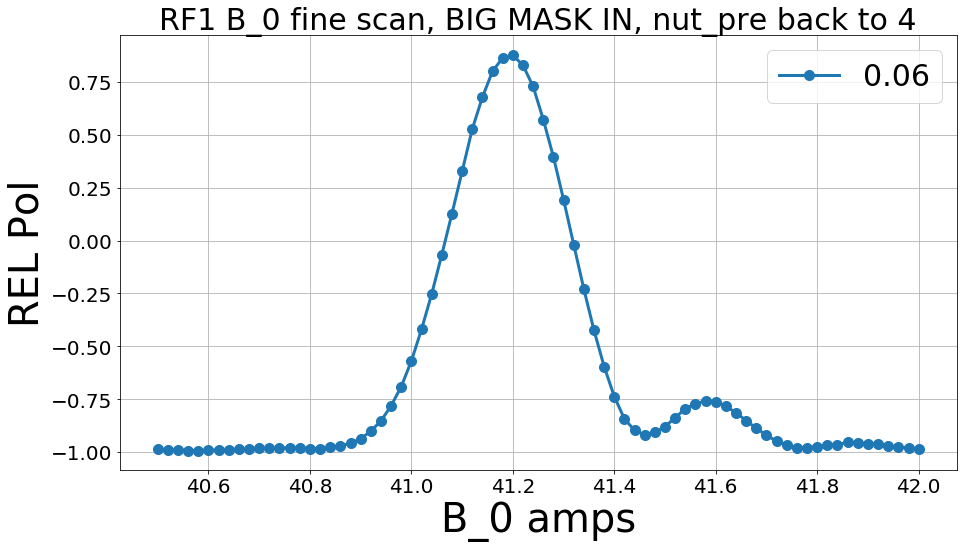

In [94]:
fig = plt.figure(figsize=(15,8))
for j in [0]:
    print('Flip efficiency percent (estimate):', round(100*get_pol(np.max(Data[default_dict['detector'],:,2*j+1])\
                                                       /np.min(Data[default_dict['detector'],:,2*j]))/base_pol,3))
    b0_high = Data[default_dict['psa'],:,0][np.argmax(Data[default_dict['detector'],:,2*j+1])]
    print('Flip b_0 value (max):', b0_high)
    b0_low = Data[default_dict['psa'],:,0][np.argmin(Data[default_dict['detector'],:,2*j+0])]
    print('Flip b_0 value (min):', b0_low, '\n')
    
    high = Data[default_dict['detector'],::,2*j+1]
    low = Data[default_dict['detector'],::,2*j+0]
    
    use_same_b0_point = True #set to true if b_0 max and min values are too different (only when scanning b2)
    
    if use_same_b0_point:
        vac_pol = [get_pol(i)/base_pol for i in high/low]
        plt.plot(Data[default_dict['psa'],::,0], vac_pol, 'o-', ms=10, linewidth=3, \
                 label=Data[default_dict['fgen_ampl'],0,2*j])
        plt.tick_params(labelsize=20)
        plt.title(Title[0], size=30)
        plt.ylabel('REL Pol', fontsize=40)
        plt.xlabel('B_0 amps', fontsize=40)
        plt.grid('on')
        plt.legend(fontsize=30)
        #print('Flip b_0 value (no shift):', Data[default_dict['psb'],:,0][np.argmax(vac_pol)])
    else:
        plt.plot(high, 'o-', ms=10, linewidth=3, label=Data[default_dict['nut_pre'],0,2*j])
        plt.plot(low, 'o-', ms=10, linewidth=3, label=Data[default_dict['nut_pre'],0,2*j])
        plt.tick_params(labelsize=20)
        plt.title(Title[0], size=30)
        plt.ylabel('REL counts', fontsize=40)
        plt.grid('on')
        plt.legend(fontsize=30)
plt.show()